# Autograd with PyTorch: Performance Comparison

This notebook compares the **hand-rolled NumPy autograd** (`2. vectorise with numpy`) with **PyTorch's autograd** (`3. autograd with pytorch`).

Both implement the same GPT architecture (`n_embd=16, n_head=4, n_layer=1, block_size=16`), but differ in:

| Aspect | NumPy (Step 2) | PyTorch (Step 3) |
|--------|---------------|------------------|
| Autograd | Hand-rolled `Tensor` class with closures | `torch.autograd` (C++ engine) |
| Optimizer | Hand-rolled Adam on arrays | `torch.optim.AdamW` |
| Forward pass | Token-by-token with KV cache | Full sequence via batched matmul + causal mask |
| Modules | Flat functions | `nn.Module` hierarchy |
| Loss | Manual `-log(softmax[target])` | `F.cross_entropy` (fused kernel) |

In [1]:
import subprocess
import sys
import json
import os
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.size'] = 12

NUMPY_DIR = os.path.join(os.path.dirname(os.path.abspath('.')), '2. vectorise with numpy')
PYTORCH_DIR = os.path.abspath('.')
print(f"NumPy dir:   {NUMPY_DIR}")
print(f"PyTorch dir: {PYTORCH_DIR}")

NumPy dir:   /Users/amaljoe/Desktop/Workspace/AI/LLMs from first principles/2. vectorise with numpy
PyTorch dir: /Users/amaljoe/Desktop/Workspace/AI/LLMs from first principles/3. autograd with pytorch


## 1. Run NumPy Version (1000 steps)

Running the original `main.py` from `2. vectorise with numpy/` — no code is copied here.

In [2]:
print("Running NumPy-vectorized microgpt (1000 steps)...")
proc = subprocess.run(
    [sys.executable, os.path.join(NUMPY_DIR, 'main.py')],
    capture_output=True, text=True, timeout=300,
    cwd=NUMPY_DIR
)
lines = proc.stdout.strip().split('\n')
for line in lines[:5] + ['...'] + lines[-8:]:
    print(line)
if proc.returncode != 0:
    print("STDERR:", proc.stderr[-500:])

Running NumPy-vectorized microgpt (1000 steps)...


num docs: 32033
vocab size: 27
num params: 4192

--- training ---
...
sample 15: jaylon
sample 16: sarein
sample 17: saysan
sample 18: vandin
sample 19: adelen
sample 20: amyan

results saved to results_numpy.json


## 2. Run PyTorch Version (1000 steps)

In [3]:
print("Running PyTorch microgpt (1000 steps)...")
proc = subprocess.run(
    [sys.executable, 'main.py'],
    capture_output=True, text=True, timeout=300,
    cwd=PYTORCH_DIR
)
lines = proc.stdout.strip().split('\n')
for line in lines[:5] + ['...'] + lines[-8:]:
    print(line)
if proc.returncode != 0:
    print("STDERR:", proc.stderr[-500:])

Running PyTorch microgpt (1000 steps)...


num docs: 32033
vocab size: 27
num params: 4240

--- training ---
...
sample 15: abana
sample 16: tarion
sample 17: aurer
sample 18: annen
sample 19: loryir
sample 20: aranen

results saved to results_pytorch.json


## 3. Load Results

In [4]:
with open(os.path.join(NUMPY_DIR, 'results_numpy.json')) as f:
    numpy_res = json.load(f)

with open('results_pytorch.json') as f:
    pytorch_res = json.load(f)

print(f"NumPy:   {len(numpy_res['loss_log'])} steps in {numpy_res['total_train_time']:.2f}s")
print(f"PyTorch: {len(pytorch_res['loss_log'])} steps in {pytorch_res['total_train_time']:.2f}s")

NumPy:   1000 steps in 6.31s
PyTorch: 1000 steps in 0.83s


## 4. Loss Curves

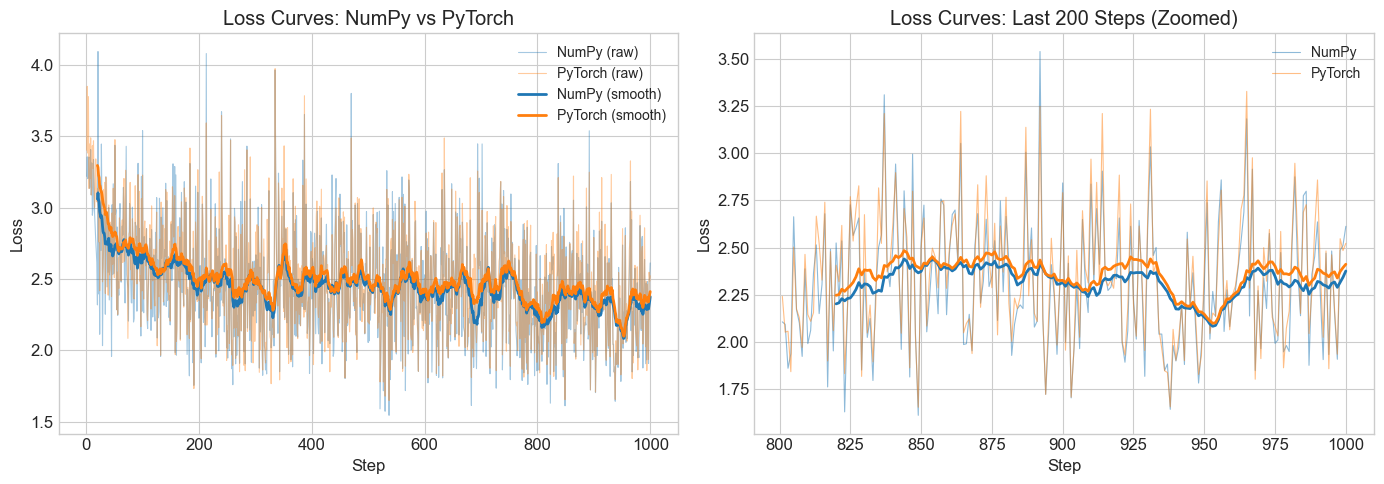

Saved: loss_curves.png


In [5]:
np_steps = [e['step'] for e in numpy_res['loss_log']]
np_losses = [e['loss'] for e in numpy_res['loss_log']]
pt_steps = [e['step'] for e in pytorch_res['loss_log']]
pt_losses = [e['loss'] for e in pytorch_res['loss_log']]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: raw loss curves overlaid
axes[0].plot(np_steps, np_losses, alpha=0.4, linewidth=0.8, color='tab:blue', label='NumPy (raw)')
axes[0].plot(pt_steps, pt_losses, alpha=0.4, linewidth=0.8, color='tab:orange', label='PyTorch (raw)')

# Smoothed
window = 20
if len(np_losses) >= window:
    np_smooth = np.convolve(np_losses, np.ones(window)/window, mode='valid')
    axes[0].plot(np_steps[window-1:], np_smooth, linewidth=2, color='tab:blue', label='NumPy (smooth)')
if len(pt_losses) >= window:
    pt_smooth = np.convolve(pt_losses, np.ones(window)/window, mode='valid')
    axes[0].plot(pt_steps[window-1:], pt_smooth, linewidth=2, color='tab:orange', label='PyTorch (smooth)')

axes[0].set_xlabel('Step')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Curves: NumPy vs PyTorch')
axes[0].legend(fontsize=10)

# Right: final 200 steps zoomed in
zoom_start = 800
axes[1].plot(np_steps[zoom_start:], np_losses[zoom_start:], alpha=0.5, linewidth=0.8, color='tab:blue', label='NumPy')
axes[1].plot(pt_steps[zoom_start:], pt_losses[zoom_start:], alpha=0.5, linewidth=0.8, color='tab:orange', label='PyTorch')
if len(np_losses) >= zoom_start + window:
    axes[1].plot(np_steps[zoom_start+window-1:], np_smooth[zoom_start:], linewidth=2, color='tab:blue')
if len(pt_losses) >= zoom_start + window:
    axes[1].plot(pt_steps[zoom_start+window-1:], pt_smooth[zoom_start:], linewidth=2, color='tab:orange')
axes[1].set_xlabel('Step')
axes[1].set_ylabel('Loss')
axes[1].set_title('Loss Curves: Last 200 Steps (Zoomed)')
axes[1].legend(fontsize=10)

plt.tight_layout()
plt.savefig('loss_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: loss_curves.png")

## 5. Timing Comparison

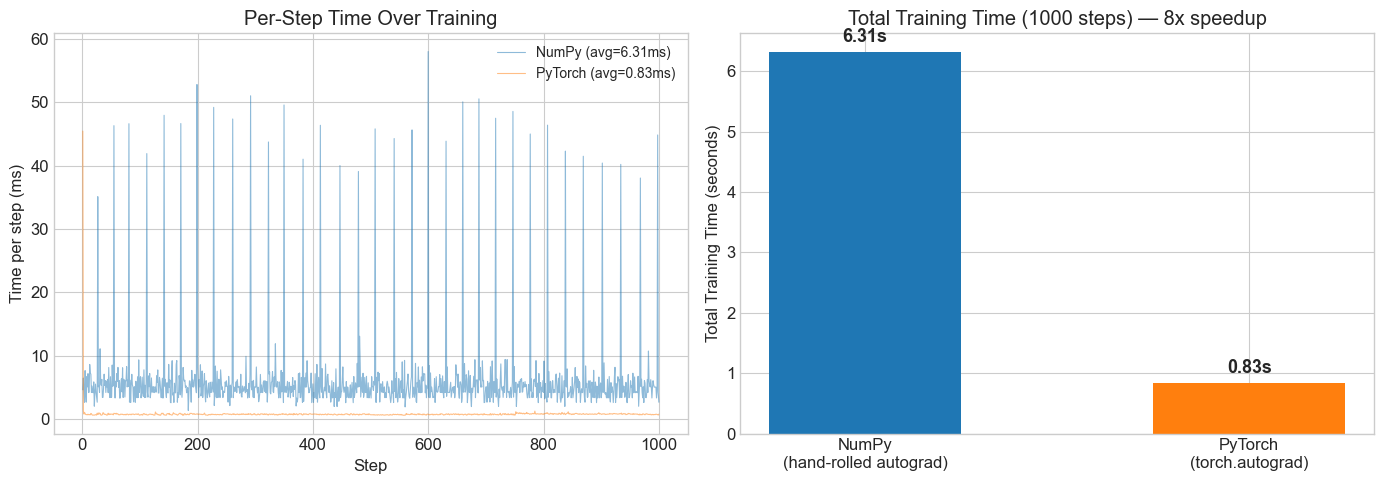

Saved: time_comparison.png


In [6]:
np_times = [e['time'] for e in numpy_res['loss_log']]
pt_times = [e['time'] for e in pytorch_res['loss_log']]

np_avg = np.mean(np_times)
pt_avg = np.mean(pt_times)
speedup = np_avg / pt_avg

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: per-step time over training
axes[0].plot(np_steps, [t * 1000 for t in np_times], alpha=0.5, linewidth=0.8, color='tab:blue', label=f'NumPy (avg={np_avg*1000:.2f}ms)')
axes[0].plot(pt_steps, [t * 1000 for t in pt_times], alpha=0.5, linewidth=0.8, color='tab:orange', label=f'PyTorch (avg={pt_avg*1000:.2f}ms)')
axes[0].set_xlabel('Step')
axes[0].set_ylabel('Time per step (ms)')
axes[0].set_title('Per-Step Time Over Training')
axes[0].legend(fontsize=10)

# Right: total time bar chart
labels = ['NumPy\n(hand-rolled autograd)', 'PyTorch\n(torch.autograd)']
times = [numpy_res['total_train_time'], pytorch_res['total_train_time']]
colors = ['tab:blue', 'tab:orange']
bars = axes[1].bar(labels, times, color=colors, width=0.5)
for bar, t in zip(bars, times):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                 f'{t:.2f}s', ha='center', va='bottom', fontweight='bold', fontsize=13)
axes[1].set_ylabel('Total Training Time (seconds)')
axes[1].set_title(f'Total Training Time (1000 steps) — {speedup:.0f}x speedup')

plt.tight_layout()
plt.savefig('time_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: time_comparison.png")

## 6. Summary Table

In [7]:
print("=" * 65)
print(f"{'Metric':<35} {'NumPy':>12} {'PyTorch':>12}")
print("=" * 65)
print(f"{'Parameters':.<35} {numpy_res['num_params']:>12,} {pytorch_res['num_params']:>12,}")
print(f"{'Training steps':.<35} {len(numpy_res['loss_log']):>12,} {len(pytorch_res['loss_log']):>12,}")
print(f"{'Avg time per step':.<35} {np_avg*1000:>10.2f}ms {pt_avg*1000:>10.2f}ms")
print(f"{'Total train time':.<35} {numpy_res['total_train_time']:>11.2f}s {pytorch_res['total_train_time']:>11.2f}s")
print(f"{'Final loss':.<35} {np_losses[-1]:>12.4f} {pt_losses[-1]:>12.4f}")
print(f"{'Speedup (per step)':.<35} {'1x':>12} {f'{speedup:.0f}x':>12}")
print("=" * 65)

if numpy_res['num_params'] != pytorch_res['num_params']:
    print(f"\nNote: param count differs because PyTorch RMSNorm has a learnable")
    print(f"'scale' parameter ({pytorch_res['num_params'] - numpy_res['num_params']} extra params).")

Metric                                     NumPy      PyTorch
Parameters.........................        4,192        4,240
Training steps.....................        1,000        1,000
Avg time per step..................       6.31ms       0.83ms
Total train time...................        6.31s        0.83s
Final loss.........................       2.6125       2.5224
Speedup (per step).................           1x           8x

Note: param count differs because PyTorch RMSNorm has a learnable
'scale' parameter (48 extra params).


## 7. Generated Samples Comparison

In [8]:
print(f"{'#':<4} {'NumPy (1000 steps)':>25} {'PyTorch (1000 steps)':>25}")
print("-" * 56)
for i in range(20):
    n = numpy_res['samples'][i] if i < len(numpy_res['samples']) else ''
    p = pytorch_res['samples'][i] if i < len(pytorch_res['samples']) else ''
    print(f"{i+1:<4} {n:>25} {p:>25}")

#           NumPy (1000 steps)      PyTorch (1000 steps)
--------------------------------------------------------
1                         gena                      mann
2                         sary                    kaylan
3                        jamya                    irilan
4                          ame                    staile
5                       analen                     janan
6                         cany                      dinn
7                        casar                      anir
8                       alydan                      alan
9                        lezan                      daya
10                       elyni                      onah
11                        anil                     erere
12                       karan                   mabyely
13                      fenlin                     jelia
14                       aliea                     kayir
15                      jaylon                     abana
16                      sarein 

## 8. What Changed: Architecture Comparison

The two implementations compute the same thing, but the code structure is fundamentally different:

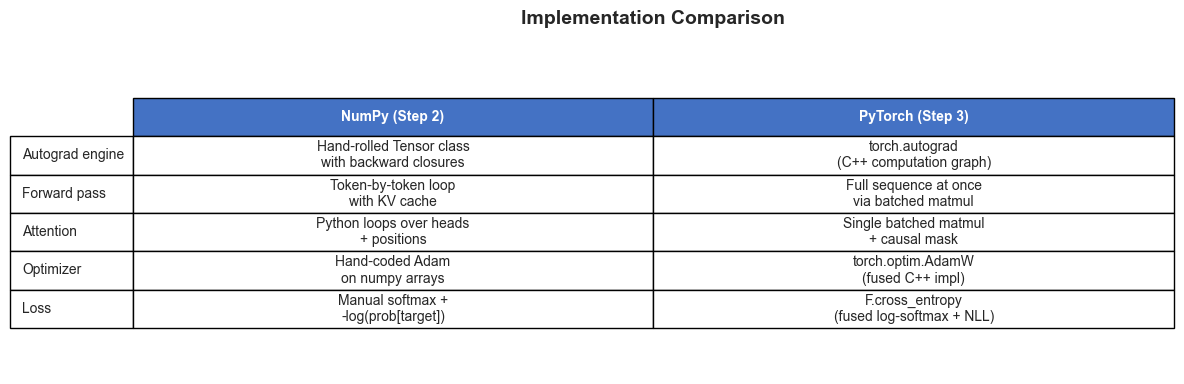

Saved: architecture_comparison.png


In [9]:
comparison = [
    ('Autograd engine', 'Hand-rolled Tensor class\nwith backward closures', 'torch.autograd\n(C++ computation graph)'),
    ('Forward pass', 'Token-by-token loop\nwith KV cache', 'Full sequence at once\nvia batched matmul'),
    ('Attention', 'Python loops over heads\n+ positions', 'Single batched matmul\n+ causal mask'),
    ('Optimizer', 'Hand-coded Adam\non numpy arrays', 'torch.optim.AdamW\n(fused C++ impl)'),
    ('Loss', 'Manual softmax +\n-log(prob[target])', 'F.cross_entropy\n(fused log-softmax + NLL)'),
]

fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('off')
table = ax.table(
    cellText=[[c[1], c[2]] for c in comparison],
    rowLabels=[c[0] for c in comparison],
    colLabels=['NumPy (Step 2)', 'PyTorch (Step 3)'],
    cellLoc='center',
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.2)

# Style header
for j in range(2):
    table[0, j].set_facecolor('#4472C4')
    table[0, j].set_text_props(color='white', fontweight='bold')

plt.title('Implementation Comparison', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('architecture_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: architecture_comparison.png")